In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
parent_dir="/content/drive/My Drive/Colab Notebooks/Rough/"                            #to be changed if run on different computers

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,UpSampling2D,Reshape,LeakyReLU,Flatten,Input,Conv2DTranspose
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from tqdm import tqdm_notebook

In [0]:
lfw=fetch_lfw_people()

In [0]:
imgs=lfw["data"]            

In [0]:
imgs=imgs.reshape(-1,62,47)
imgs.shape

(13233, 62, 47)

In [0]:
rdim=imgs.shape[1]
cdim=imgs.shape[2]

In [0]:
imgs=(imgs-127.5)/127.5
imgs

array([[[-0.73333335, -0.7699346 , -0.82483655, ..., -0.84313726,
         -0.7986928 , -0.75947714],
        [-0.70718956, -0.7490196 , -0.80130714, ..., -0.8352941 ,
         -0.7908497 , -0.7490196 ],
        [-0.7385621 , -0.74640524, -0.68366015, ..., -0.8143791 ,
         -0.78039217, -0.7202614 ],
        ...,
        [ 0.3019608 , -0.23921569, -0.6522876 , ..., -0.924183  ,
         -0.8875817 , -0.903268  ],
        [-0.49803922, -0.696732  , -0.7647059 , ..., -0.9006536 ,
         -0.8745098 , -0.8901961 ],
        [-0.75947714, -0.77254903, -0.793464  , ..., -0.8849673 ,
         -0.8745098 , -0.8901961 ]],

       [[ 0.23921569,  0.26013076,  0.330719  , ..., -0.41699344,
         -0.78039217, -0.8771242 ],
        [ 0.22352941,  0.21830061,  0.2810457 , ..., -0.34901962,
         -0.7986928 , -0.8901961 ],
        [ 0.15032683,  0.12679742,  0.13464056, ..., -0.35424834,
         -0.79607844, -0.8849673 ],
        ...,
        [-0.06928106, -0.05882353,  0.33333334, ...,  

In [0]:
imgs.shape

(13233, 62, 47)

In [0]:
new_imgs=[]
for i in tqdm_notebook(range(imgs.shape[0])):
    new_imgs.append(cv2.resize(imgs[i],(40,40)))
imgs=np.array(new_imgs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
imgs.shape

(13233, 40, 40)

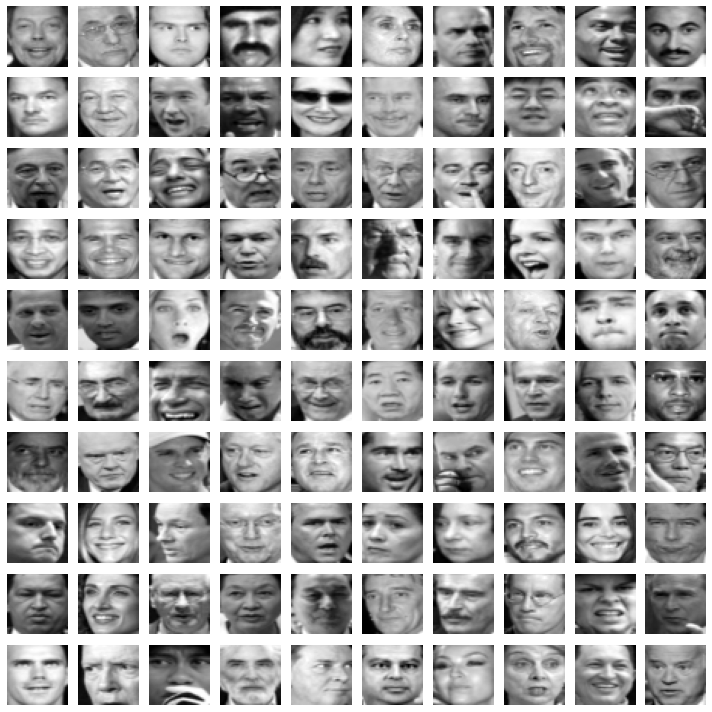

In [0]:
ax=plt.figure(figsize=(10,10))
for i in range(100): 
    ax.add_subplot(10,10,i+1)
    plt.imshow(imgs[i],cmap="gray")

    plt.axis("off")
    plt.tight_layout()
plt.show()

In [0]:
imgs=imgs.reshape(-1,imgs.shape[1],imgs.shape[2],1)
imgs.shape

(13233, 40, 40, 1)

In [0]:
n_epochs=120
batch_size=256
n_batches=int(imgs.shape[0]/batch_size)
noise_dim=100

opt=Adam(lr=2e-4,beta_1=0.5)

In [0]:
gen=Sequential()                                   

gen.add(Dense(5*5*128,input_shape=(noise_dim,)))
gen.add(Reshape((5,5,128)))
gen.add(LeakyReLU(0.2))
gen.add(BatchNormalization())

gen.add(UpSampling2D((2,2)))                                         #doubles the size of the image (if it was (x,x), it will become (2x,2x))
gen.add(Conv2D(64,(5,5),padding="same"))                             #reduces the no. of channels from 128 to 64
#gen.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding="same")) 
gen.add(LeakyReLU(0.2))
gen.add(BatchNormalization())

gen.add(UpSampling2D((2,2)))                                         #doubles the size of the image (if it was (x,x), it will become (2x,2x))
gen.add(Conv2D(32,(5,5),padding="same"))                             #reduces the no. of channels from 128 to 64
#gen.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding="same")) 
gen.add(LeakyReLU(0.2))
gen.add(BatchNormalization())

gen.add(UpSampling2D((2,2)))                                         
gen.add(Conv2D(1,(5,5),padding="same",activation="tanh"))            #reduces the no. of channels from 64 to 1
#gen.add(Conv2DTranspose(1,(5,5),padding="same",strides=(2,2),activation="tanh"))
gen.add(BatchNormalization())

gen.compile(optimizer=opt,loss="binary_crossentropy")
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3200)              323200    
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 10, 64)        0

In [0]:
disc=Sequential()                 

disc.add(Conv2D(32,(5,5),strides=2,padding="same",input_shape=(40,40,1)))       #this will convert the image from (40,40,1) to (20,20,64)
disc.add(LeakyReLU(0.2))

disc.add(Conv2D(64,(5,5),strides=2,padding="same"))                             #this will convert the image from (20,20,1) to (10,10,128)
disc.add(LeakyReLU(0.2))

disc.add(Conv2D(128,(5,5),strides=2,padding="same"))                            #this will convert the image from (20,20,1) to (10,10,128)
disc.add(LeakyReLU(0.2))

disc.add(Flatten())
disc.add(Dense(1,activation="sigmoid"))

disc.compile(loss="binary_crossentropy",optimizer=opt)
disc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 20, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)             

In [0]:
disc.trainable=False

gan_input=Input(shape=(noise_dim,))
gen_img=gen(gan_input)
gan_output=disc(gen_img)

model=Model(gan_input,gan_output)
model.compile(loss="binary_crossentropy",optimizer=opt)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 40, 40, 1)         580997    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 260225    
Total params: 841,222
Trainable params: 580,547
Non-trainable params: 260,675
_________________________________________________________________


In [0]:
def show_imgs(n_samples=100):                        #n_samples is the no. of images that u want to plot
    
    noise=np.random.normal(0,1,size=(n_samples,noise_dim))
    gen_imgs=gen.predict(noise)
    gen_imgs=gen_imgs.reshape(-1,gen_imgs.shape[1],gen_imgs.shape[2])

    ax=plt.figure(figsize=(10,10))
    for i in range(n_samples):
        plt.subplot(10,10,i+1)
        plt.imshow(gen_imgs[i],cmap='gray')

        plt.axis("off")
        plt.tight_layout()

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


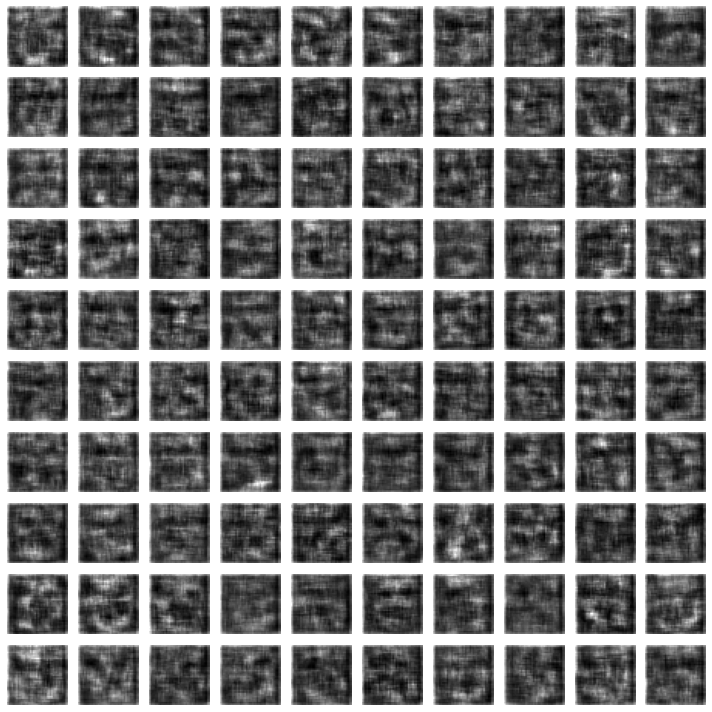

Epoch:  0  Average Discriminator Loss:  0.0785209879395552  Average Generator Loss:  0.020754658305577323


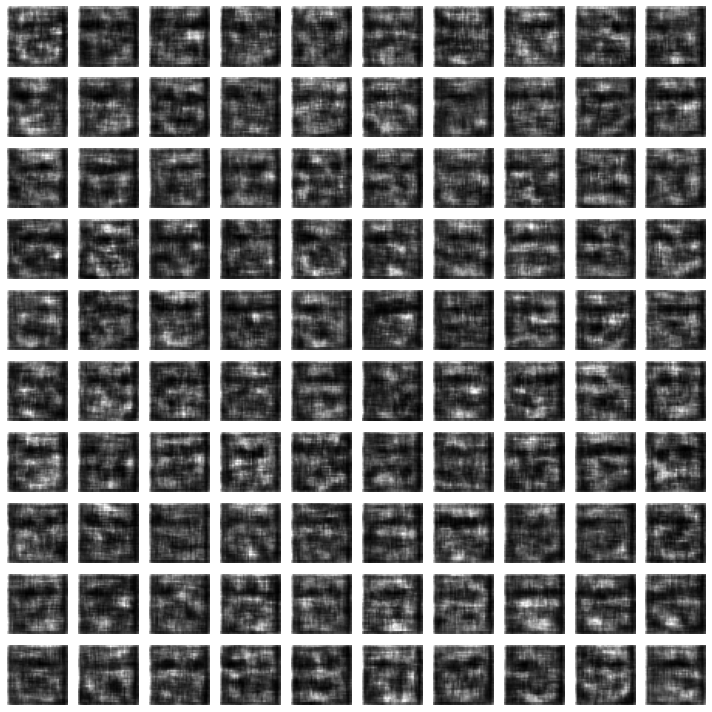

Epoch:  1  Average Discriminator Loss:  0.03583000344224274  Average Generator Loss:  0.0001679111119301524


In [0]:
gloss=[]
dloss=[]

for i in tqdm_notebook(range(n_epochs)):

    gen_loss=0
    disc_loss=0

    for batch in range(n_batches):

        #Training the Discriminator:
        random_idx=np.random.randint(0,imgs.shape[0],size=int(batch_size/2))
        real_imgs=imgs[random_idx]
        real_labels=np.ones(int(batch_size/2))*0.9

        noise=np.random.normal(0,1,size=(int(batch_size/2),noise_dim))
        fake_imgs=gen.predict(noise)
        fake_labels=np.zeros(int(batch_size/2))

        total_imgs=np.vstack((real_imgs,fake_imgs))
        total_labels=np.hstack((real_labels,fake_labels))

        disc_loss+=disc.train_on_batch(total_imgs,total_labels)

        #Training the Generator:
        noise=np.random.normal(0,1,size=(batch_size,noise_dim))
        labels=np.ones(batch_size)

        gen_loss+=model.train_on_batch(noise,labels)

    show_imgs()

    print("Epoch: ",i," Average Discriminator Loss: ",disc_loss/batch_size," Average Generator Loss: ",gen_loss/batch_size)

    gloss.append(gen_loss/batch_size)
    dloss.append(disc_loss/batch_size)

    if i>0 and gloss[-2]>gloss[-1]:
        gen.save(parent_dir+"deep_conv_gan_lfw.h5")

In [0]:
show_imgs()

In [0]:
e=np.arange(n_epochs)
plt.plot(e,gloss,c="g")
plt.plot(e,dloss,c="r")

plt.show()